# Heart Disease Diagnosis

This project has been completed as a final project for *BME 440 - Introductory Python with Biomedical Applications* at Washington University in St. Louis. The project has been completed with **Arthur Li (arthurli@wustl.edu)** and **Sai Akhil Pulikam**.

The majority of the contents of this notebook have been adapted from the initial project proposal, the code file, and the final report, but additional explanations have been added for better readability.

## Background
### Biomedical/Healthcare Need
Cardiovascular diseases are a major risk factor that compromises the health of children, men, and women in the US. Heart diseases cost the United States approximately \\$363 billion each year, and the cost is ever-growing. The average cost of most common diagnostic tests for heart diseases such as EKGs and exercise stress tests are \\$50 and \>\\$175, respectively. Sometimes, the high cost of diagnosing the disease leads to a disproportionate amount of deaths in households with lower income. Therefore, there is a need for a low-cost diagnostic product that assists patients to gauge their risk of developing heart diseases so that they can make informed decisions whether to visit a clinic to receive the actual test or not. 

(Reference: https://www.cdc.gov/heartdisease/facts.htm, https://www.choosingwisely.org/patient-resources/ekgs-and-exercise-stress-tests/)

### Project Overview
The final outcome of this project would be to create an interactive software that uses answers to a set of questions to determine whether a patient is at either a high risk or low risk of having heart diseases. Additionally, there would be a functionality to search for nearby hospitals based on the patient's provided current location. 

## Loading and Preparing Data

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import sys
import re
import warnings
warnings.filterwarnings("ignore")

The 'Heart Disease Dataset' https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset by Cleveland Clinic Foundation was downloaded from *Kaggle* and loaded into the notebook.

In [134]:
# Load the dataset
heart = pd.read_csv("./data/heart.csv")

# Print out the shape
print("The shape is (rows, colums): ", heart.shape)

# Print out the first 5 rows of the dataset
heart.head()

The shape is (rows, colums):  (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [135]:
# Check if there are any missing values
print("Number of rows with missing values for each variable")
for col in heart.columns:
    missing_rows = heart.loc[heart[col]==np.nan].shape[0]
    print(col + ": " + str(missing_rows))

Number of rows with missing values for each variable
age: 0
sex: 0
cp: 0
trestbps: 0
chol: 0
fbs: 0
restecg: 0
thalach: 0
exang: 0
oldpeak: 0
slope: 0
ca: 0
thal: 0
target: 0


In [136]:
# Check the data types of each column
heart.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

The dataset contains 1025 rows and 14 columns and there are no explicit missing/invalid data. However, before we move on to EDA, we should compare what are actually the valid values for each column and remove those rows with invalid values. The following are explanations of all features of the dataset and what their valid inputs are:
1. age: age in years
2. sex: sex (0 = female; 1 = male)
3. cp: chest pain type (0 = typical angina; 1 = atypical angina; 2 = non-anginal pain, 3 = asymptomatic)
4. trestbps: resting blood pressure (in mmHg on admission to the hospital)
5. chol: serum cholesterol in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl (0 = false; 1 = true)
7. restecg: resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality; 2 = showing probable or definite left ventricular hypertrophy by Estes’ criteria)
8. thalach: maximum heart rate achieved (in bpm)
9. exang: exercise induced angina (0 = no; 1 = yes)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment (0 = upsloping; 1 = flat; 2 = downsloping)
12. ca: number of major vessels (0-3) colored by fluoroscopy
13. thal: thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)
14. num: diagnosis of heart disease (0 = <50% diameter narrowing; 1 = >50% diameter narrowing)

In [138]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


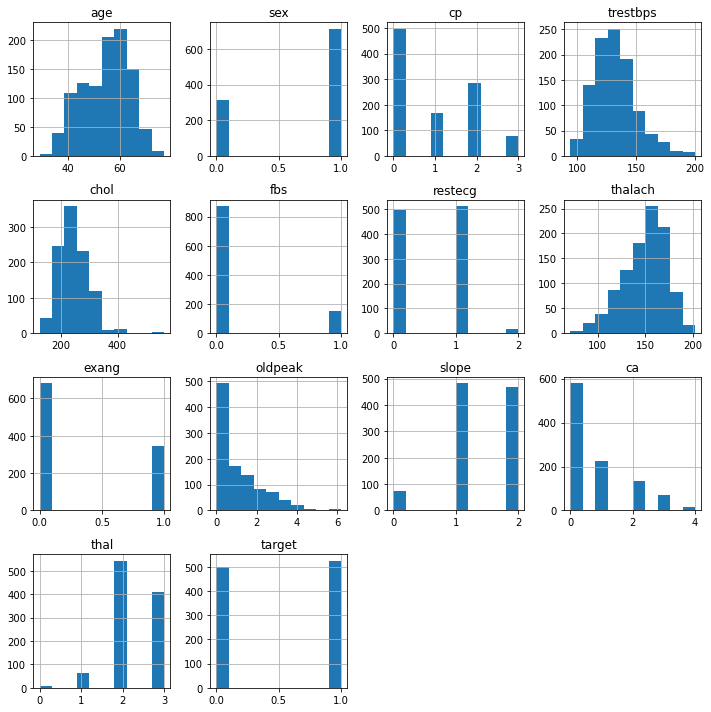

In [61]:
# Plotting histograms for individual columns
heart.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

Comparing the attribute information given by the creators of the dataset against the statistical analysis and histograms, some invalid data have been identified in the dataset.

1) The variable \'ca\' must have integer values of 0-3. However, there are a small number of data points that are 4. 

2) The variable \'thal\' must range between integer values of 1 and 3. However, there are a small number of zeros.

Since these are invalid data points, they should be removed and the new size of the dataset is now (1000, 14), with 25 rows removed.

In [140]:
heart = heart[(heart.ca != 4) & (heart.thal != 0)]
heart.shape

(1000, 14)

## Exploratory Data Analysis with Density Plots

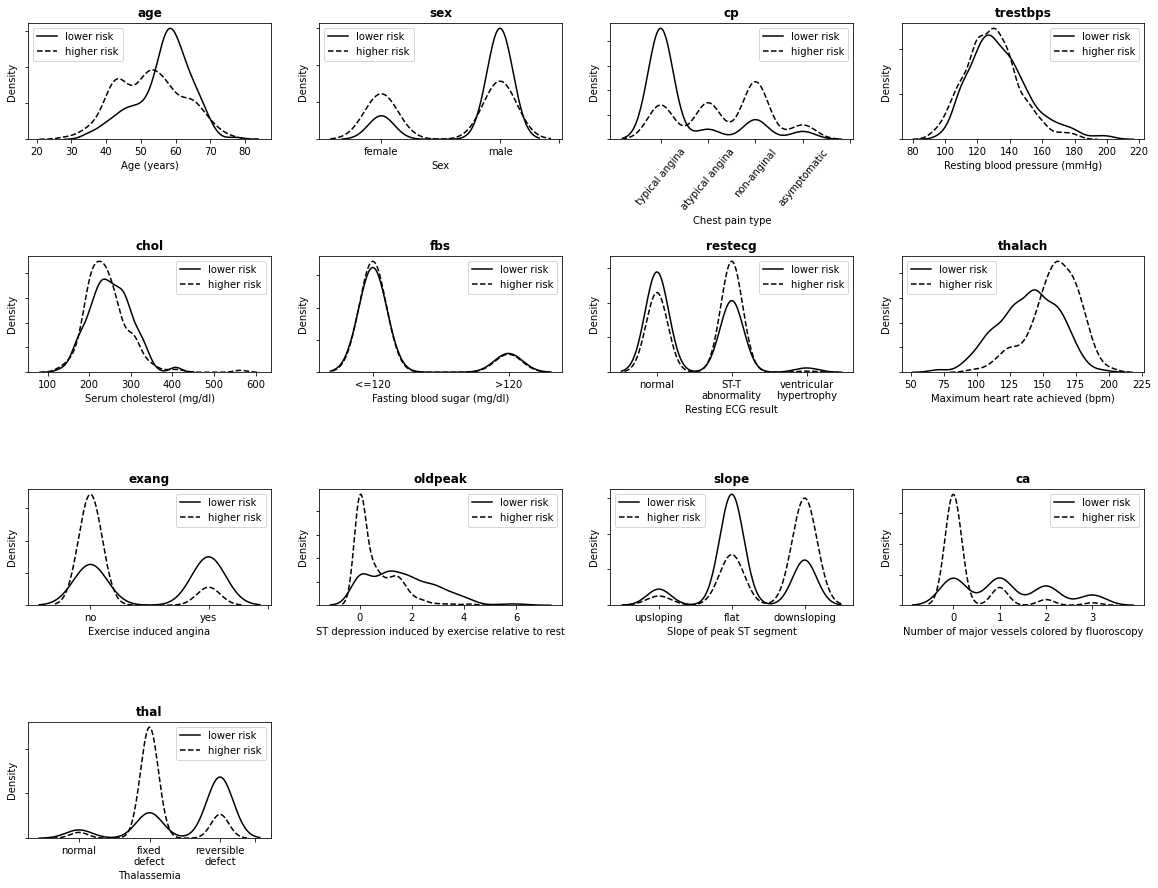

In [144]:
# Create a subplot of 3 x 5
plt.subplots(4,4,figsize=(20,15))

# Configure x-axis labels and tickmarks
xlabels = ['Age (years)', 'Sex', 'Chest pain type', 'Resting blood pressure (mmHg)', 'Serum cholesterol (mg/dl)',
           'Fasting blood sugar (mg/dl)', 'Resting ECG result', 'Maximum heart rate achieved (bpm)',
           'Exercise induced angina', 'ST depression induced by exercise relative to rest', 'Slope of peak ST segment', 
           'Number of major vessels colored by fluoroscopy', 'Thalassemia', '', '', '']

# Plot a density plot for each variable
for idx, col in enumerate(heart.columns):
    ax = plt.subplot(4,4,idx+1)
    ax.yaxis.set_ticklabels([])
    sns.distplot(heart.loc[heart.target == 0][col], hist=False, axlabel= True, 
    kde_kws={'linestyle':'-',  
    'color':'black', 'label':"No Stroke"})
    sns.distplot(heart.loc[heart.target == 1][col], hist=False, axlabel= True, 
    kde_kws={'linestyle':'--', 
    'color':'black', 'label':"Stroke"})
    ax.set_title(col, fontweight='bold')
    ax.legend(['lower risk', 'higher risk'])
    ax.set_xlabel(xlabels[idx])
    if col == 'sex':
        ax.set_xticklabels(['','','female','','male'])
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[3].set_visible(False)
    if col == 'cp':
        ax.set_xticklabels(['','','typical angina','atypical angina','non-anginal','asymptomatic'], rotation=50)
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
    if col == 'fbs':
        ax.set_xticklabels(['','','<=120','','','','>120'])
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[3].set_visible(False)
        xticks[4].set_visible(False)
        xticks[5].set_visible(False)
        xticks[7].set_visible(False)
    if col == 'restecg':
        ax.set_xticklabels(['','','normal','','ST-T\nabnormality','','ventricular\nhypertrophy'])
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[3].set_visible(False)
        xticks[5].set_visible(False)
        xticks[7].set_visible(False)
    if col == 'exang':
        ax.set_xticklabels(['','','no','','yes'])
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[3].set_visible(False)
    if col == 'slope':
        ax.set_xticklabels(['','','upsloping','','flat','','downsloping'])
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[3].set_visible(False)
        xticks[5].set_visible(False)
        xticks[7].set_visible(False)
    if col == 'ca':
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[6].set_visible(False)
    if col == 'thal':
        ax.set_xticklabels(['','','normal','','fixed\ndefect','','reversible\ndefect'])
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].set_visible(False)
        xticks[1].set_visible(False)
        xticks[3].set_visible(False)
        xticks[5].set_visible(False)

plt.subplots_adjust(hspace=1)

# Hide the 9th subplot (bottom right) since there are only 8 plots
plt.subplot(4,4,14).set_visible(False)
plt.subplot(4,4,15).set_visible(False)
plt.subplot(4,4,16).set_visible(False)

plt.show()

Density plots show the distribution of variables in the dataset. The **solid lines** in this case represent the distribution of patients who have a **lower risk** of developing cardiovascular diseases while the **dotted lines** represent the distribution of patients who have a **higher risk**. A few of the variables in this dataset have categorical values instead of numerical values. Since the original dataset represents categorical variables with integer values for the ease of model-building in the later steps, the labels for the x-tickmarks are confusing left as these integer encodings. Therefore, the plots have been manipulated so that these integer labels are replaced with text labels.

From the observation of the density plots, the following features are likely to lead to higher probabilities of developing heart diseases:
- having non-anginal pain
- resting ECG revealing ST-T wave abnormality
- higher maximum heart rate achieved
- absence of exercise induced angina
- fewer ST depression induced by exercise relative to rest
- downsloping peack ST segment
- fewer number of major vessels colored by fluoroscopy
- fixed defects for patients with thalassemia

## Model Training

### Splitting and Fitting

In [63]:
# Split dataset
X_heart = np.array(heart[heart.columns[0:13]])
y_heart = np.array(heart['target'])

# Fit the model with test data = 20% of the data using train_test_split
X1, X2, y1, y2 = train_test_split(X_heart, y_heart, random_state=0, train_size = 0.8) # Selecting random_state=0 to facilitate later discussions

# Build a model of the data with decision tree
model = svm.SVC(random_state=0)

# Provide cross-validation scores for this model with 10-fold cross-validation
cross_val_score(model, X_heart, y_heart, cv=10)

array([0.65048544, 0.69902913, 0.77669903, 0.67961165, 0.69902913,
       0.73529412, 0.64705882, 0.64705882, 0.70588235, 0.65686275])

### Helper Functions

In [64]:
def get_classfication_report():
    model.fit(X1, y1)  # Fit (train) the model on 80%
    y2_model = model.predict(X2) # Evaluate the model on the other 20%

    # Provide a classification report
    print(classification_report(y2, y2_model))
    
def plot_confusion():
  # Visualize our outcome with a Confusion Matrix
  plt.figure()
  y_test_pred = model.predict(X2)
  c_matrix = confusion_matrix(y2, y_test_pred)
  ax = sns.heatmap(c_matrix, annot=True, 
                  xticklabels=['Heart Disease Unlikely','Heart Disease Likely'],
                  yticklabels=['Heart Disease Unlikely','Heart Disease Likely'], 
                  cbar=False, cmap='Blues')
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Actual")
  # Top left is True Negative, Bottom left is False Negative, Top right is False Positive and Bottom Right is True Positive.

def plot_roc():
  # Make a receiver operating characteristic (ROC) curve.
  plt.figure()
  y_test_pred_probs = model.predict(X2)
  FPR, TPR, _ = roc_curve(y2, y_test_pred_probs)

  auc=roc_auc_score(y2, y_test_pred_probs)
  plt.plot(FPR, TPR)
  plt.plot([0,1],[0,1],'--', color='black') #diagonal line
  title=f"ROC Curve {auc:.2f}"
  plt.title(title)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

              precision    recall  f1-score   support

           0       0.77      0.67      0.72        98
           1       0.73      0.81      0.77       107

    accuracy                           0.75       205
   macro avg       0.75      0.74      0.74       205
weighted avg       0.75      0.75      0.74       205



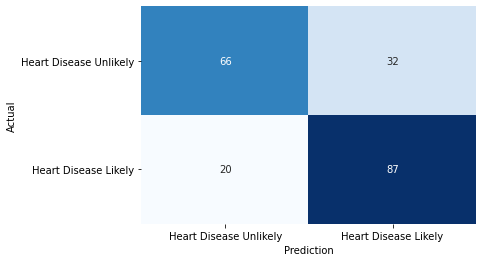

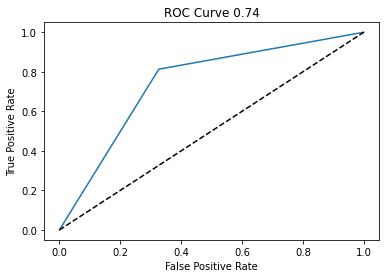

In [65]:
# Get model preformence
get_classfication_report()
plot_confusion()
plot_roc()